In [405]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm

# Definir a semente para reprodução dos resultados
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [406]:
#Leitura de dados
df = pd.read_csv('data_per_month.csv')

In [407]:
#Visualização da base de dados
df.head()

,Year,Month,Day,Total Renewable Energy,Data Time
0,1973,1,26,219.840,1973-01-26
1,1973,2,26,197.330,1973-02-26
2,1973,3,26,218.687,1973-03-26
3,1973,4,26,209.330,1973-04-26
4,1973,5,26,215.982,1973-05-26


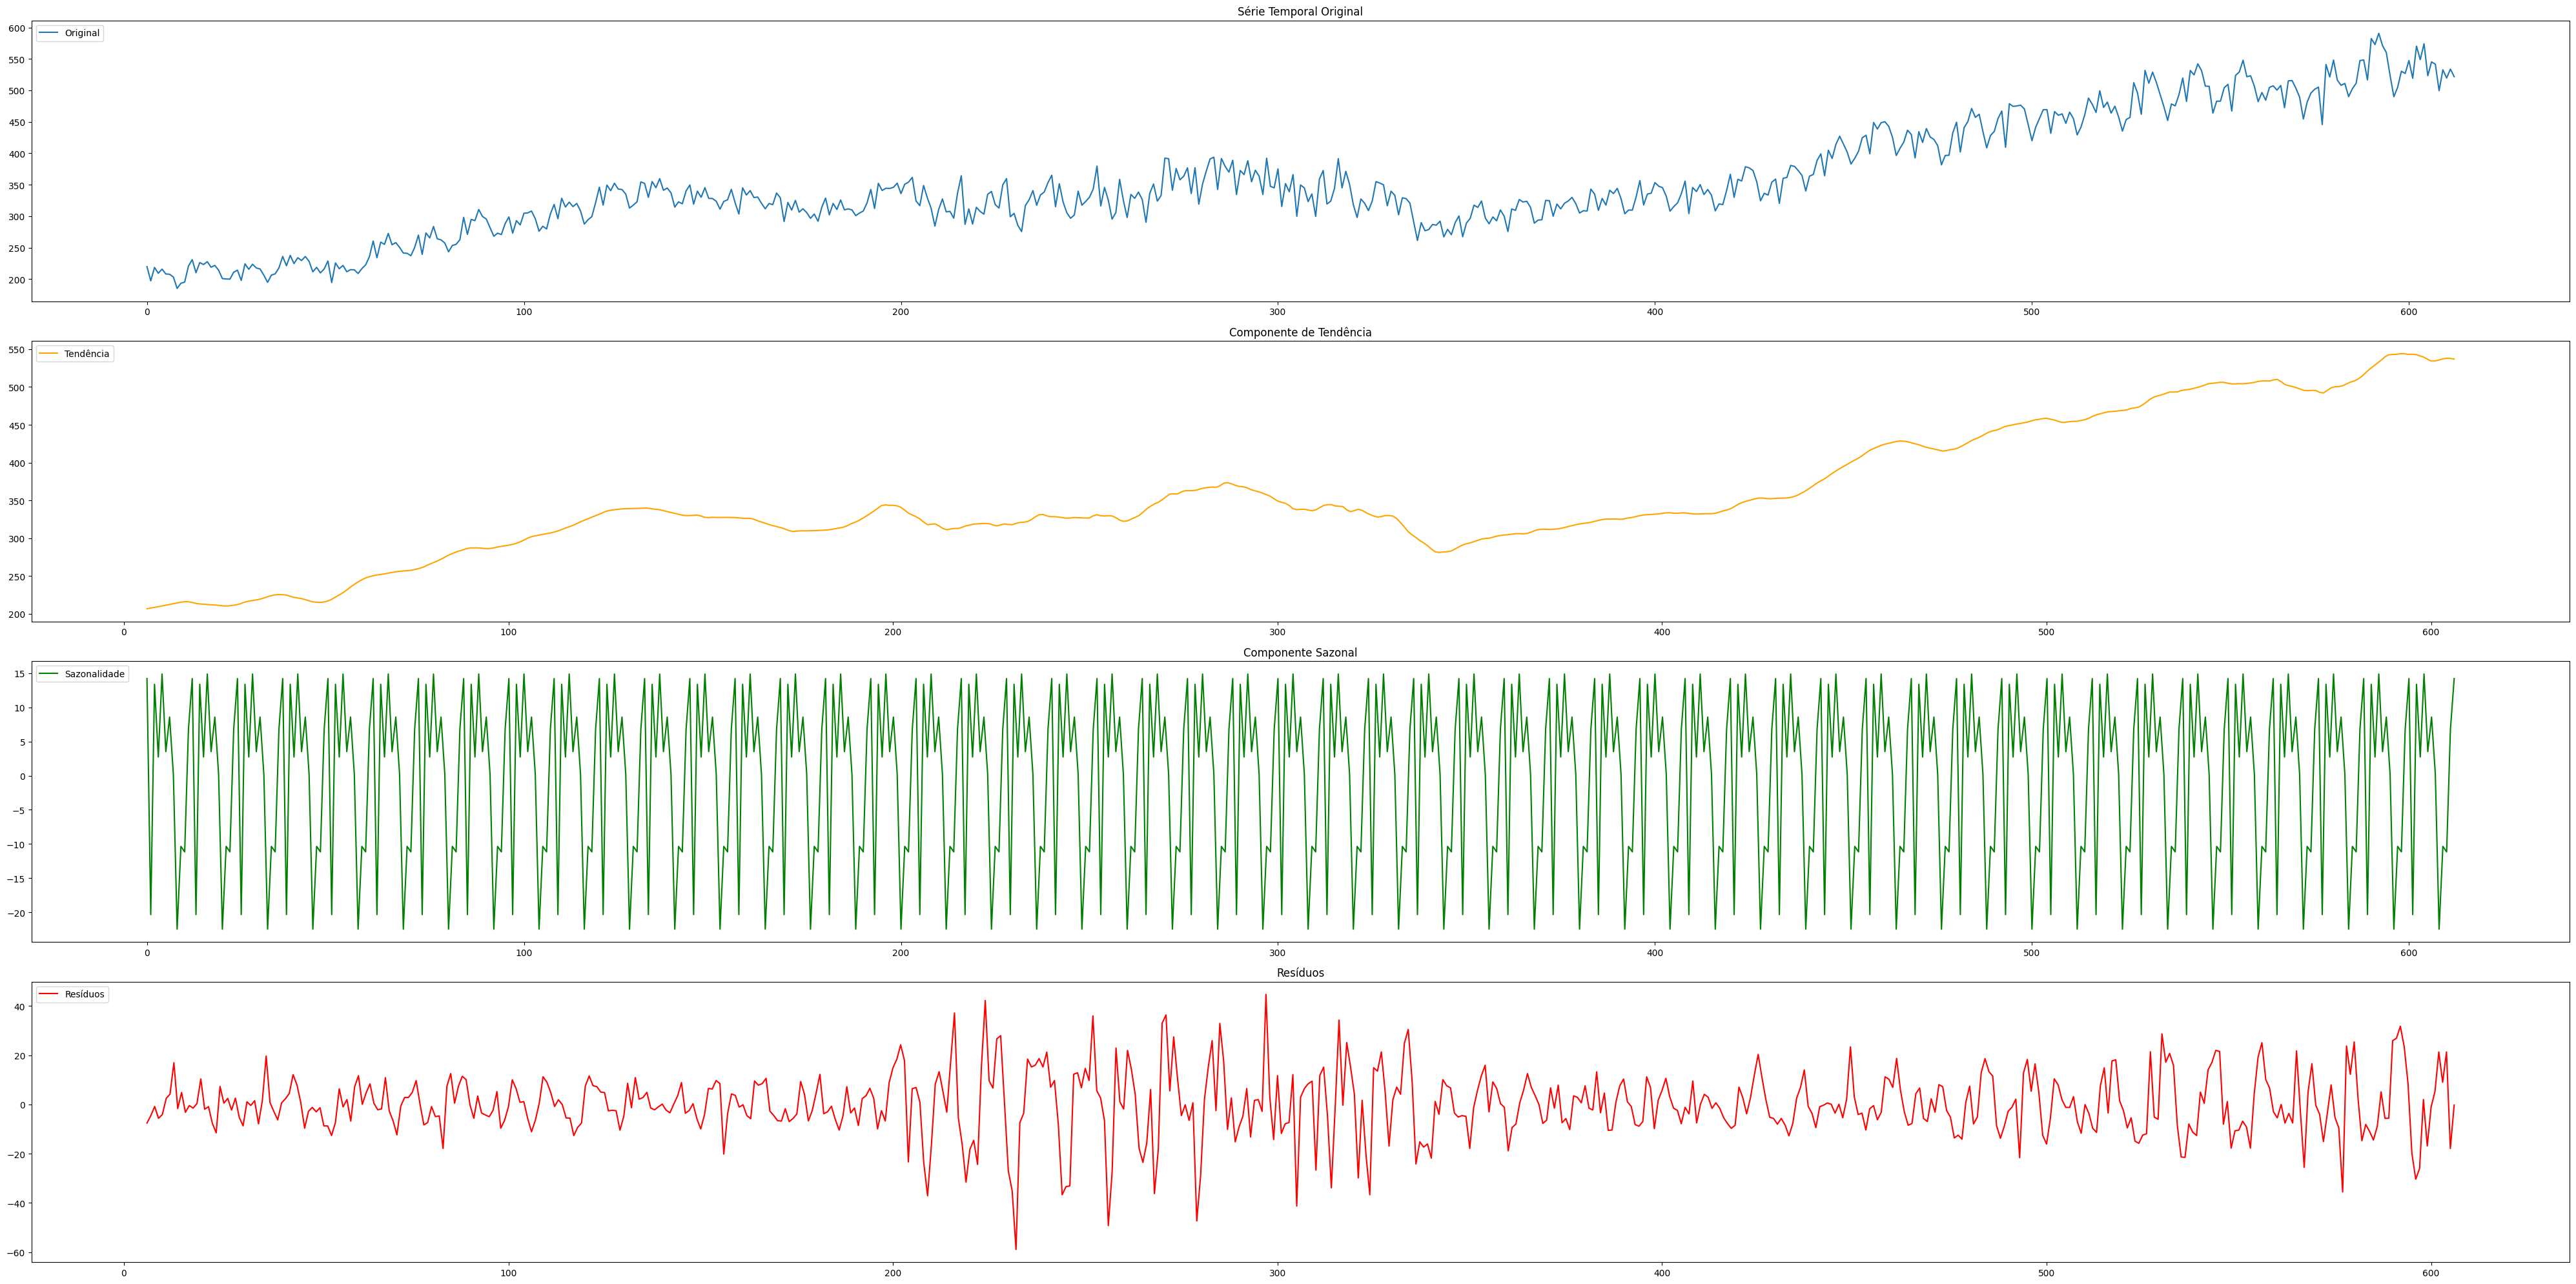

In [408]:
# Decompondo a série temporal
decomposicao = seasonal_decompose(df['Total Renewable Energy'], model='additive', period=12)  # 'period=12' para sazonalidade anual # Talvez mudar sazonalidade?

# Plotando os componentes
plt.figure(figsize=(40, 20))

plt.subplot(411)
plt.plot(df['Total Renewable Energy'], label='Original')
plt.legend(loc='upper left')
plt.title('Série Temporal Original')

plt.subplot(412)
plt.plot(decomposicao.trend, label='Tendência', color='orange')
plt.legend(loc='upper left')
plt.title('Componente de Tendência')

plt.subplot(413)
plt.plot(decomposicao.seasonal, label='Sazonalidade', color='green')
plt.legend(loc='upper left')
plt.title('Componente Sazonal')

plt.subplot(414)
plt.plot(decomposicao.resid, label='Resíduos', color='red')
plt.legend(loc='upper left')
plt.title('Resíduos')

plt.tight_layout()
plt.show()


In [409]:
data = df.copy()

train_size = int(len(data) * 0.8)  # 80% treino, 20% teste
train, test = data[:train_size], data[train_size:]

In [410]:
train

,Year,Month,Day,Total Renewable Energy,Data Time
0,1973,1,26,219.840,1973-01-26
1,1973,2,26,197.330,1973-02-26
2,1973,3,26,218.687,1973-03-26
3,1973,4,26,209.330,1973-04-26
4,1973,5,26,215.982,1973-05-26
...,...,...,...,...,...
485,2013,6,26,457.129,2013-06-26
486,2013,7,26,462.057,2013-07-26
487,2013,8,26,434.547,2013-08-26
488,2013,9,26,408.686,2013-09-26


In [411]:
from statsmodels.tsa.stattools import adfuller

# Executar o teste ADF na série original
result = adfuller(train['Total Renewable Energy'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Transformação Logarítmica
train = train.copy()
train.loc[:, 'Log'] = np.log(train['Total Renewable Energy'])
# Verificando a série transformada
print(train)

ADF Statistic: -0.8973051747779103
p-value: 0.7888585668091624
     Year  Month  Day  Total Renewable Energy   Data Time       Log
0    1973      1   26                 219.840  1973-01-26  5.392900
1    1973      2   26                 197.330  1973-02-26  5.284877
2    1973      3   26                 218.687  1973-03-26  5.387641
3    1973      4   26                 209.330  1973-04-26  5.343912
4    1973      5   26                 215.982  1973-05-26  5.375195
..    ...    ...  ...                     ...         ...       ...
485  2013      6   26                 457.129  2013-06-26  6.124966
486  2013      7   26                 462.057  2013-07-26  6.135688
487  2013      8   26                 434.547  2013-08-26  6.074304
488  2013      9   26                 408.686  2013-09-26  6.012947
489  2013     10   26                 428.271  2013-10-26  6.059756

[490 rows x 6 columns]


1
0
0
ADF Statistic: -6.142712799282531
p-value: 7.900331345240322e-08


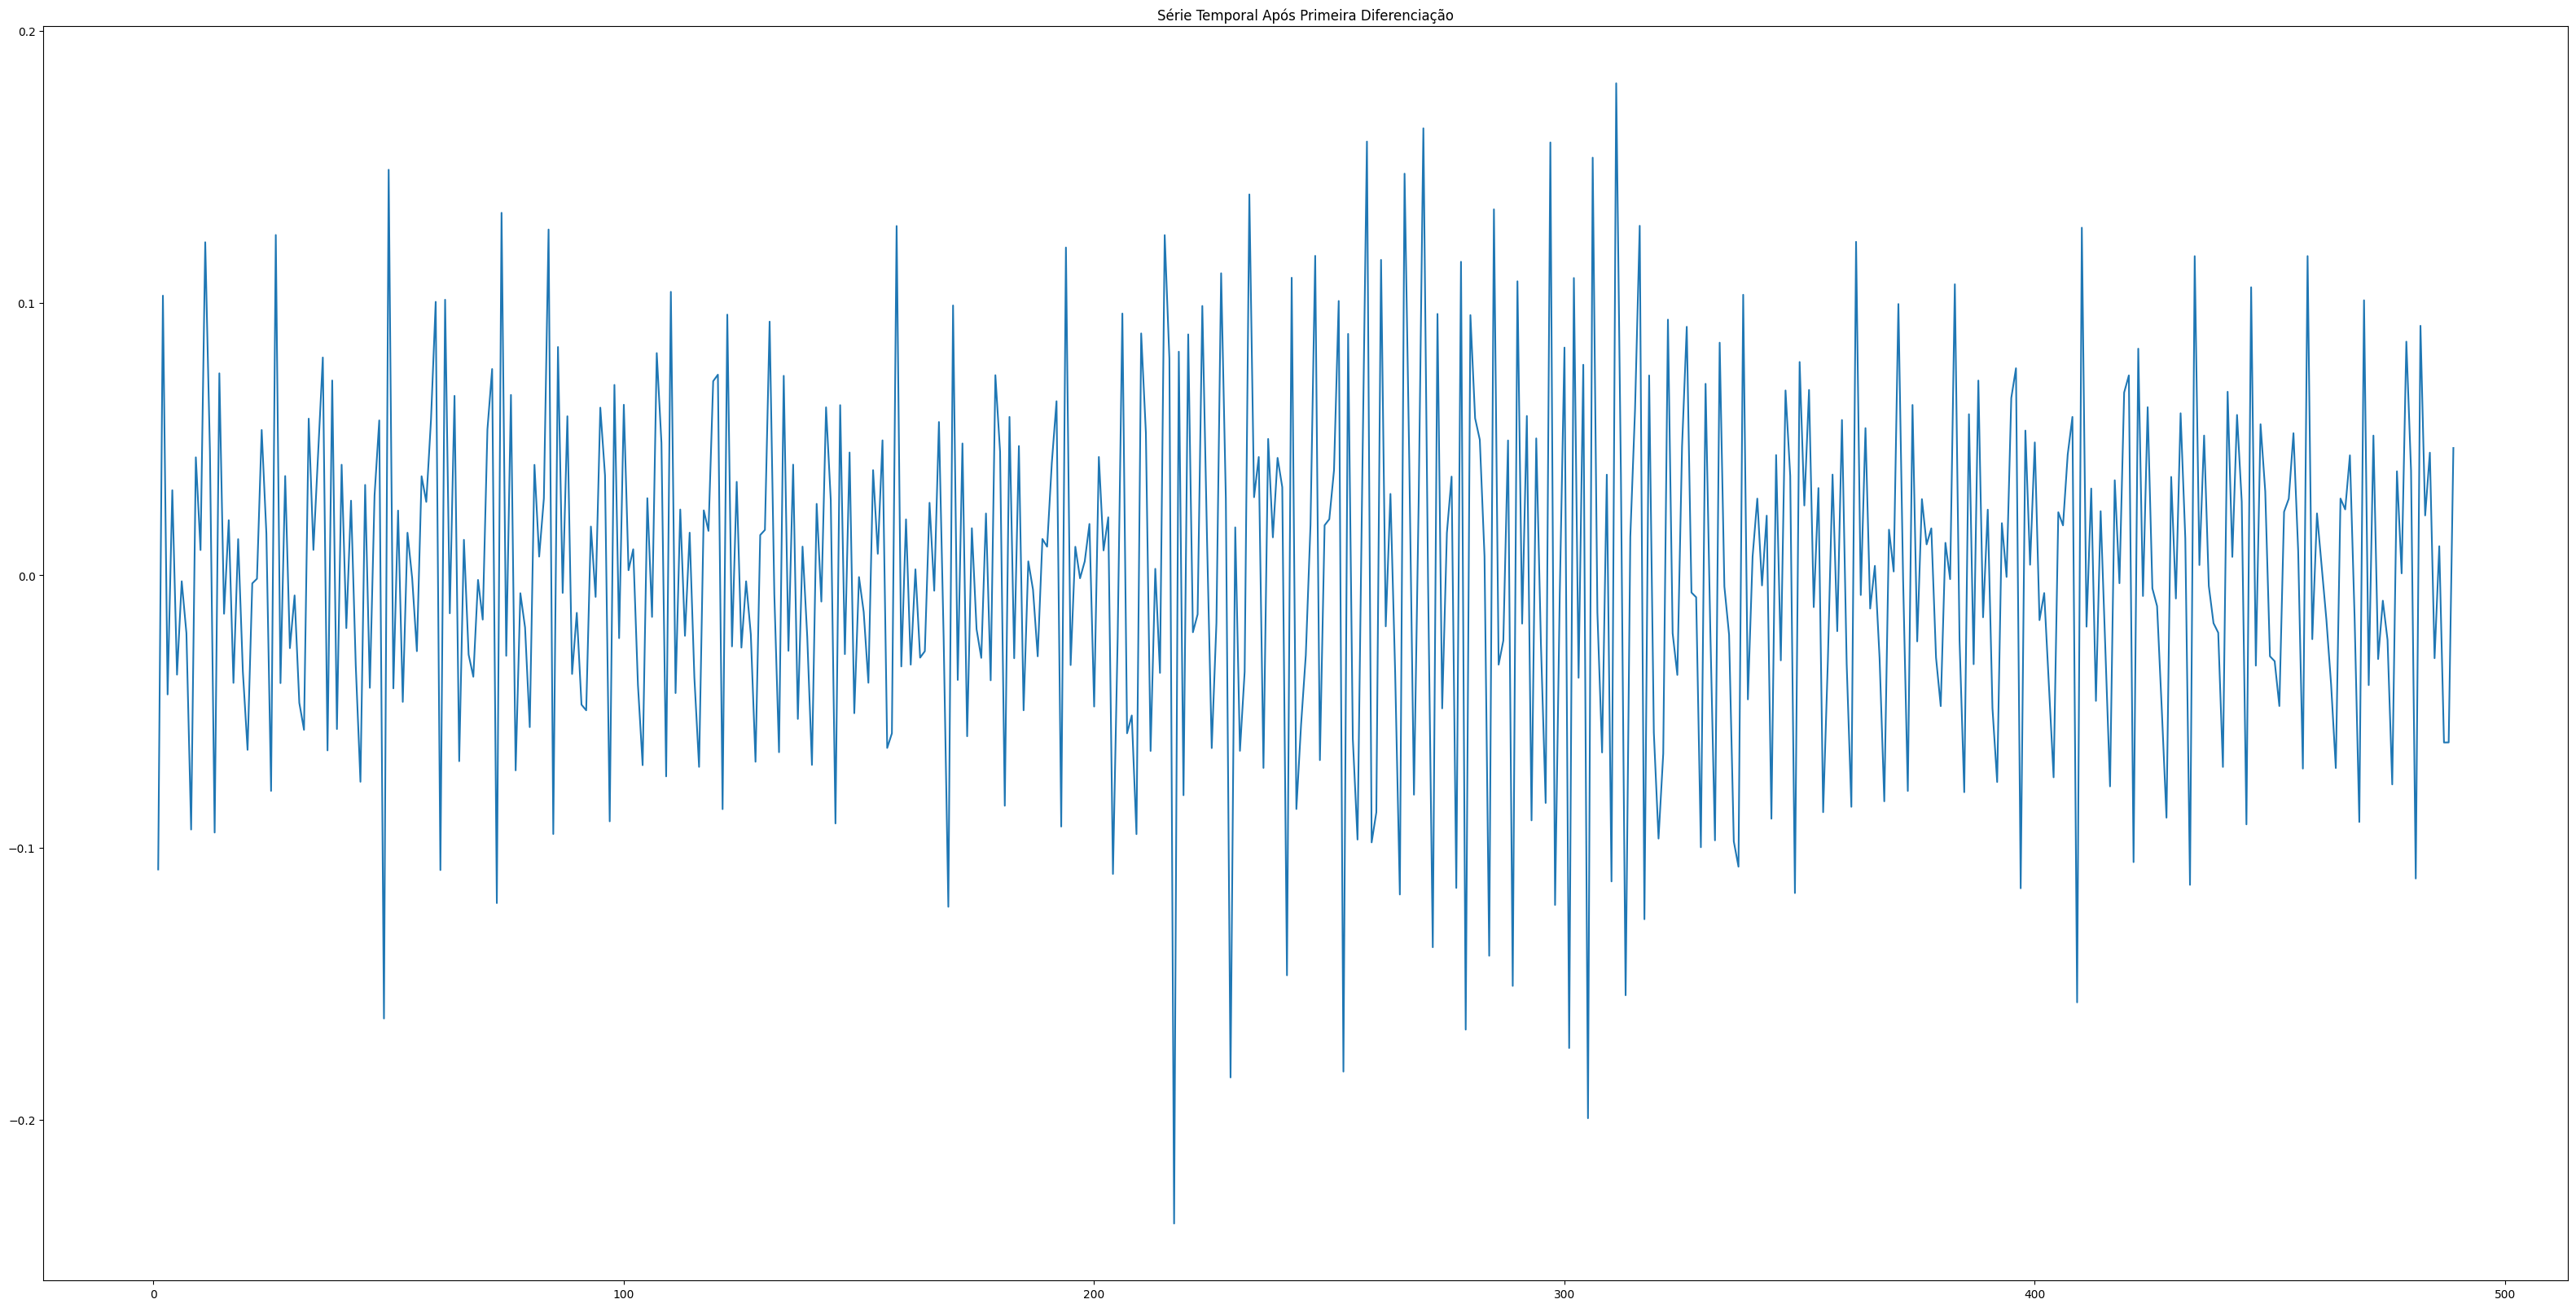

,Year,Month,Day,Total Renewable Energy,Data Time,Log,Diff
1,1973,2,26,197.330,1973-02-26,5.284877,-0.108023
2,1973,3,26,218.687,1973-03-26,5.387641,0.102764
3,1973,4,26,209.330,1973-04-26,5.343912,-0.043730
4,1973,5,26,215.982,1973-05-26,5.375195,0.031283
5,1973,6,26,208.249,1973-06-26,5.338734,-0.036461
...,...,...,...,...,...,...,...
485,2013,6,26,457.129,2013-06-26,6.124966,-0.030415
486,2013,7,26,462.057,2013-07-26,6.135688,0.010723
487,2013,8,26,434.547,2013-08-26,6.074304,-0.061384
488,2013,9,26,408.686,2013-09-26,6.012947,-0.061357


In [412]:
# Aplicar a primeira diferenciação
initial_value = train['Log'].loc[0]
train.loc[:, ['Diff']] = train['Log'].diff().dropna()

# Verificar se há valores NaN ou Inf no DataFrame
print(train['Diff'].isna().sum())  # Contar quantos NaN existem
print((train['Diff'] == np.inf).sum())  # Contar quantos Inf existem

# Remover valores NaN ou Inf
train_cleaned = train['Diff'].replace([np.inf, -np.inf], np.nan).dropna()

# Verifique novamente
print(train_cleaned.isna().sum())  # Agora deve ser 0

# Agora execute o teste ADF
result_diff1 = adfuller(train_cleaned)
print('ADF Statistic:', result_diff1[0])
print('p-value:', result_diff1[1])

# Plotar a série diferenciada
plt.figure(figsize=(40, 20))
plt.plot(train['Diff'])
plt.title('Série Temporal Após Primeira Diferenciação')
plt.show()

train = train.dropna()
train

# train['Diff'] = pd.DataFrame(train['Diff'])

In [413]:
test['Total Renewable Energy']

490    434.697
491    455.327
492    467.204
493    409.626
494    478.790
        ...   
608    499.536
609    532.762
610    519.638
611    533.819
612    521.761
Name: Total Renewable Energy, Length: 123, dtype: float64

In [414]:
test = test.copy()

# 🔹 4. Aplicar as mesmas transformações no teste
test.loc[:, 'Log'] = np.log(test['Total Renewable Energy'])

# Para a diferenciação no teste, precisamos do último valor do treino!
last_train_log = train['Log'].iloc[-1]  # Último valor do log no treino
test.loc[:, 'Diff'] = test['Log'].diff()

# Corrigir o primeiro valor de 'Diff' da série de teste
test.iloc[0, test.columns.get_loc('Diff')] = test.iloc[0, test.columns.get_loc('Log')] - last_train_log

# Exibir a série de diferenças corrigida
print(test['Diff'])

490    0.014893
491    0.046367
492    0.025750
493   -0.131521
494    0.156018
         ...   
608   -0.080959
609    0.064395
610   -0.024942
611    0.026924
612   -0.022847
Name: Diff, Length: 123, dtype: float64


In [415]:
from sklearn.metrics import mean_absolute_error

# Configuração da validação cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop para treinar e validar o modelo em cada divisão
for fold, (train_idx, val_idx) in enumerate(tscv.split(train['Diff']), 1):
    train_cross, val = train['Diff'].iloc[train_idx], train['Diff'].iloc[val_idx]
    
    # Modelo simples: previsão pela média dos dados de treino
    pred = np.mean(train_cross)  
    mae = mean_absolute_error(val, np.full_like(val, pred))  

    print(f"Fold {fold}: {len(train_cross)} treino - {len(val)} validação | MAE: {mae:.4f}")

Fold 1: 84 treino - 81 validação | MAE: 0.0430
Fold 2: 165 treino - 81 validação | MAE: 0.0548
Fold 3: 246 treino - 81 validação | MAE: 0.0802
Fold 4: 327 treino - 81 validação | MAE: 0.0460
Fold 5: 408 treino - 81 validação | MAE: 0.0476


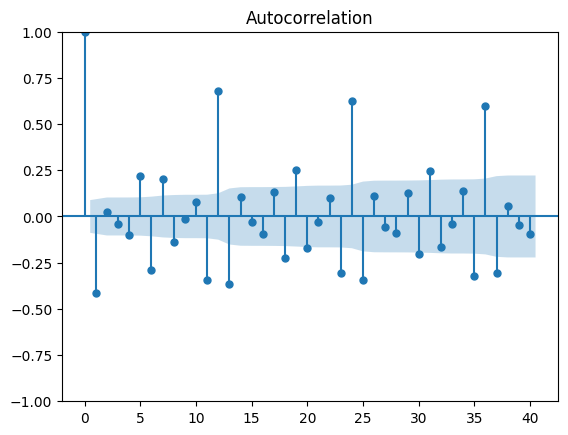

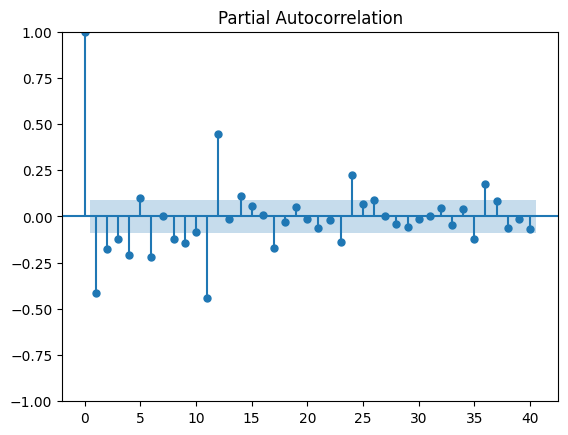

In [416]:
sm.graphics.tsa.plot_acf(train['Diff'], lags=40)
sm.graphics.tsa.plot_pacf(train['Diff'], lags=40)
plt.show()

In [417]:
train.loc[:, 'Data Time'] = pd.to_datetime(train['Data Time'])
test.loc[:, 'Data Time'] = pd.to_datetime(test['Data Time'])

train['Diff'] = pd.to_numeric(train['Diff'], errors='coerce')
train = train.dropna(subset=['Diff'])  # Remove valores nulos após a conversão


C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

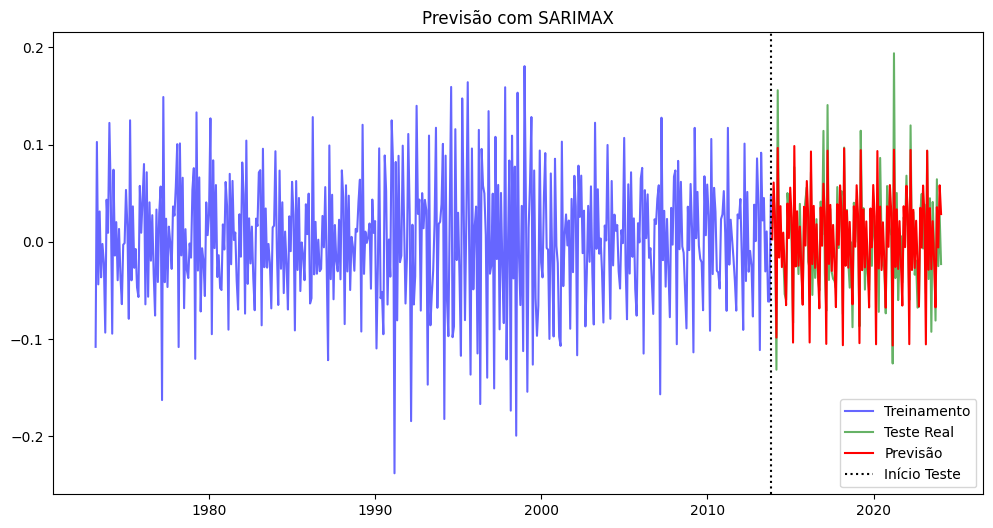

In [418]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Certificando-se de que 'Date Time' é o índice
train.set_index('Data Time', inplace=True)
test.set_index('Data Time', inplace=True)

# 1. Criar e treinar o modelo SARIMAX com os dados de treino (considerando 'Diff')
model = SARIMAX(train['Diff'], order=(2, 1, 3), seasonal_order=(6, 1, 4, 12))
result = model.fit()

# 2. Fazer previsões no conjunto de teste
forecast = result.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# 3. Visualização do gráfico
plt.figure(figsize=(12, 6))

# Plotando a série real (transformada)
plt.plot(train.index, train['Diff'], label="Treinamento", color='blue', alpha=0.6)
plt.plot(test.index, test['Diff'], label="Teste Real", color='green', alpha=0.6)

# Plotando a previsão
plt.plot(test.index, forecast, label="Previsão", color='red')

# Linha preta indicando o início do conjunto de teste
plt.axvline(train.index[-1], color='black', linestyle="dotted", label="Início Teste")

# Títulos e legendas
plt.title("Previsão com SARIMAX")
plt.legend()

# Exibir o gráfico
plt.show()


In [419]:
import numpy as np

# Passo 1: Reverter a diferenciação
# Pega o último valor de treino logaritmico (que foi usado para calcular a diferenciação)
last_value_train_log = train['Log'].iloc[-1]  # Último valor logarítmico do treino

# Passo 2: Obter os dados diferenciais reais e as previsões
y_true_differenced = np.array(test['Diff'])  # Valores reais após diferenciação
y_pred_differenced = np.array(forecast)  # Previsões feitas pelo modelo SARIMAX

# Passo 3: Reverter a diferenciação acumulada
y_true_log = [last_value_train_log]
y_pred_log = [last_value_train_log]

# Reconstrução da série logarítmica revertida para valores reais
for i in range(len(y_true_differenced)):
    y_true_log.append(y_true_log[-1] + y_true_differenced[i])
    y_pred_log.append(y_pred_log[-1] + y_pred_differenced[i])

# Excluir o primeiro valor, pois já foi incluído no passo anterior
y_true_log = np.array(y_true_log[1:])
y_pred_log = np.array(y_pred_log[1:])

# Passo 4: Reverter a transformação logarítmica da série principal
y_true = np.exp(y_true_log)  # Reverter log para os valores reais
y_pred = np.exp(y_pred_log)

# Agora, y_true e y_pred têm os valores reais
print("Valores reais (y_true):", y_true)
print("Previsões (y_pred):", y_pred)


Valores reais (y_true): [434.697 455.327 467.204 409.626 478.79  474.589 475.262 476.481 470.433
 445.808 419.991 441.605 455.589 469.336 469.363 431.845 466.347 460.445
 462.66  447.584 465.431 455.21  429.216 441.545 461.083 487.703 477.842
 464.937 499.447 472.904 481.405 463.898 474.859 457.59  435.264 453.691
 456.997 512.267 495.995 462.003 531.83  511.38  528.94  512.696 493.573
 474.164 452.177 478.405 475.38  493.289 519.69  482.451 531.604 524.639
 542.202 531.17  506.718 506.462 463.886 482.929 482.835 504.249 509.569
 467.153 523.732 529.297 547.983 521.71  523.244 506.551 482.086 496.629
 484.52  504.754 507.264 500.406 507.808 472.531 515.144 515.615 503.627
 489.21  454.524 481.387 495.713 501.844 505.139 445.715 541.15  521.355
 548.219 516.331 508.011 511.003 490.112 502.648 511.292 547.309 548.431
 516.613 582.368 572.819 590.693 571.056 560.166 523.505 489.925 504.875
 530.425 526.825 547.463 519.312 570.317 548.92  574.094 523.358 545.288
 541.66  499.536 532.762 51

R^2: 0.7735178216906772
RMSE: 17.505261619982512
Similaridade de Cosseno: 0.9993840100289156
MAE: 13.705687981100699
Desvio Padrão (Valores Reais): 36.78337621394673
Desvio Padrão (Valores Preditos): 32.93045803077354


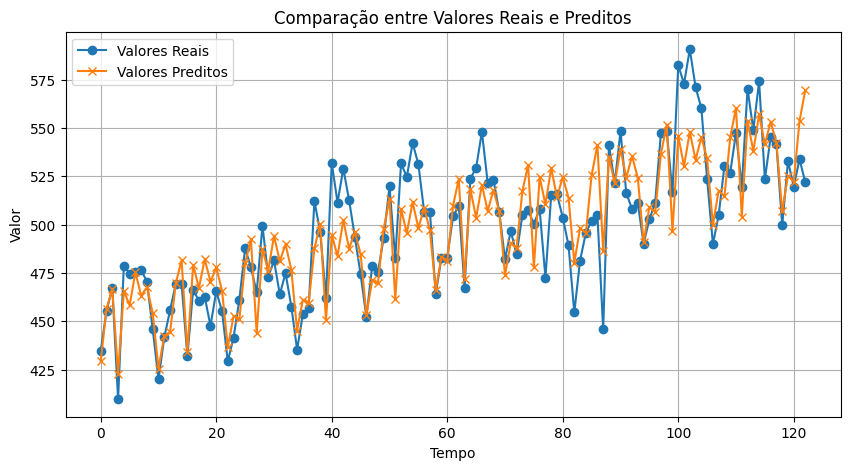

Porcentagem de erro: 2.76%
MAPE: 2.72%
Acurácia (dentro de 5% de tolerância): 84.55%


In [420]:
# Passo 5: Calcular as métricas
# Calcular R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2: {r2}')

# Calcular RMSE
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f'RMSE: {rmse}')

# Calcular Similaridade de Cosseno
y_true_reshaped = y_true.reshape(1, -1)
y_pred_reshaped = y_pred.reshape(1, -1)
cosine_sim = cosine_similarity(y_true_reshaped, y_pred_reshaped)[0][0]
print(f'Similaridade de Cosseno: {cosine_sim}')

# Calcular MAE (Erro Absoluto Médio)
mae = np.mean(np.abs(y_true - y_pred))
print(f'MAE: {mae}')

# Calcular Desvio Padrão
y_true_std = np.std(y_true)
y_pred_std = np.std(y_pred)
print(f'Desvio Padrão (Valores Reais): {y_true_std}')
print(f'Desvio Padrão (Valores Preditos): {y_pred_std}')

# Passo 6: Plotando o gráfico
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Valores Preditos', marker='x')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais e Preditos')
plt.legend()
plt.grid()
plt.show()

valores_reais = y_true  # Intervalo de valores fornecido

# Cálculo da média dos valores reais
media_valores_reais = sum(y_true) / len(y_true)

# Cálculo da porcentagem de erro
porcentagem_erro = (mae / media_valores_reais) * 100

# Exibição do resultado
print(f"Porcentagem de erro: {porcentagem_erro:.2f}%")


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape:.2f}%')

# Definir um limiar de tolerância (exemplo: 5% do valor real)
tolerance = 0.05  # 5%

# Calcular a proporção de previsões dentro do limiar
correct_predictions = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
accuracy = np.mean(correct_predictions) * 100  # Em porcentagem

print(f"Acurácia (dentro de {tolerance * 100:.0f}% de tolerância): {accuracy:.2f}%")

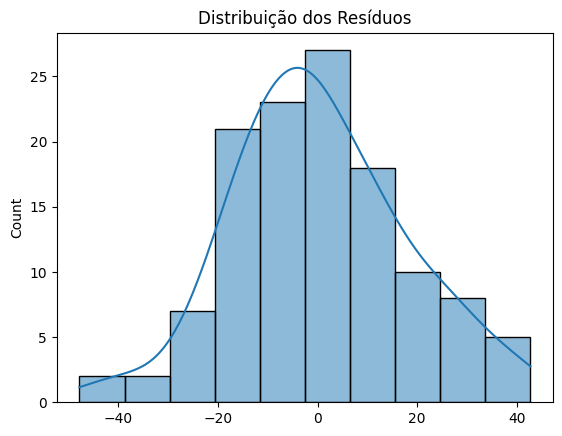

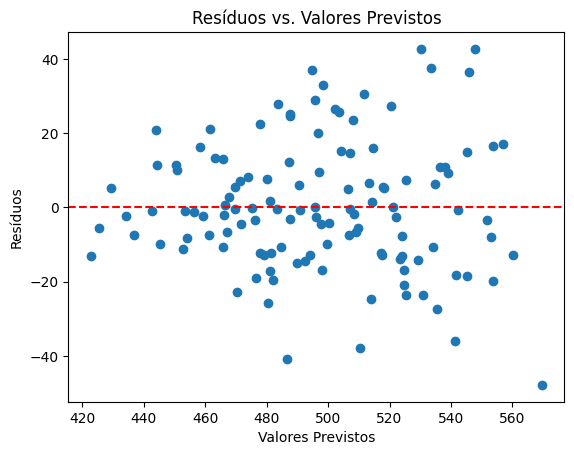

In [421]:
import seaborn as sns

# Suponha que temos y_real (dados reais) e y_pred (previsões)
residuos = y_true - y_pred

# Histograma dos resíduos
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

# Resíduos vs. valores previstos
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs. Valores Previstos")
plt.show()
